1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


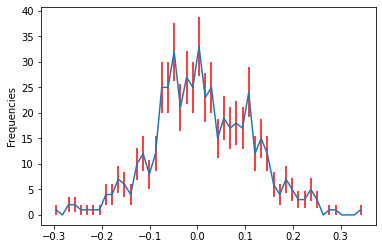

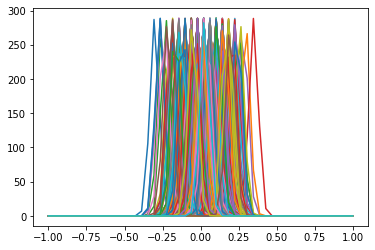

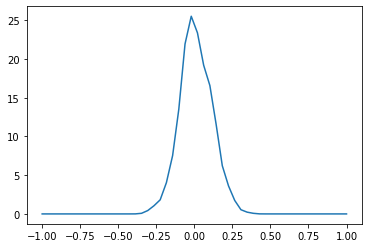

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats,integrate

#1
mu, sigma = 0, 0.1 # mean and standard deviation
x = np.random.normal(mu, sigma, 500)

#2
n, bins, patches = plt.hist(x, bins=50)  # output is two arrays
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
plt.close()
plt.figure()
plt.errorbar(bins_mean,n,n**0.5,ecolor='red')
plt.ylabel('Frequencies')

#3
sigma_x=1.06*x.std()*x.size**(-1/5)
def gauss(mu,sig,x):
    N=1/(2*(sig**2)*(np.pi**0.5))
    return N*np.e**(-((x-mu)**2)/(2*sig**2))
x_gauss=np.linspace(-1,1)

y_gauss=[]
for i in range(len(x)):
    y_gauss.append(gauss(x[i],sigma_x,x_gauss))
y_gauss=np.array(y_gauss)
#4
plt.figure()
for y in y_gauss:
    plt.plot(x_gauss,y)
    
#5
y_new=np.sum(y_gauss,axis=0)
y_new=y_new*integrate.trapz(n,bins_mean)/integrate.trapz(y_new,x_gauss)

plt.figure()
plt.plot(x_gauss,y_new)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-25 11:30:51--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-25 11:30:51--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc553f93470050fea781fa35d608.dl.dropboxusercontent.com/cd/0/inline/BD2oMQA0iRRYs5AYXCAYx15WWt1-m5lcF-Rn2TM919-z_VcJHh36Ej0D9XGoyhgYU9wZ6OgSbUhFoxUeFgK-TkQ-4a-iO-PVto32DBsNxLJp4Q/file# [segue]
--2020-11-25 11:30:51--  https://uc553f93470050fea781fa35d608.dl.dropboxusercontent.com/cd/0/inline/BD2oMQA0iRRYs5AYXCAYx15WWt1-m5lcF-Rn2TM919-z_VcJH

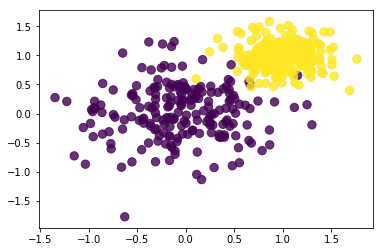

In [73]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

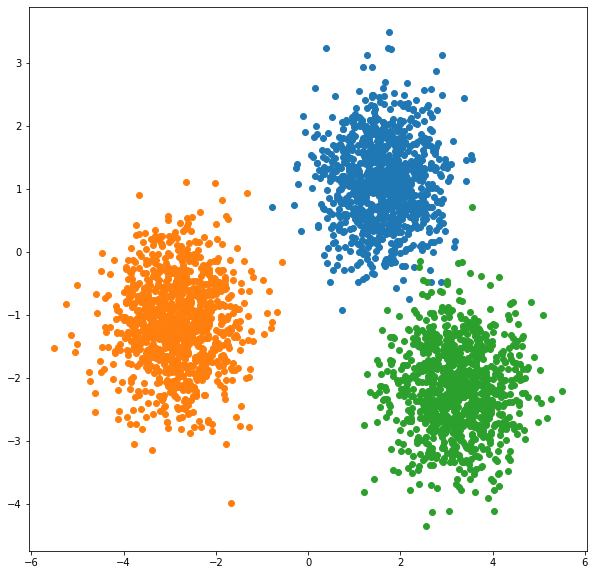

In [134]:
n=3
plt.figure(figsize=(10,10))
for i in range(n):
    mean=np.random.rand(2,)*8-4
    cov=np.array([[1,0] , [0,1]])*0.5
    x=np.random.multivariate_normal(mean, cov, 1000).T
    plt.scatter(x[0],x[1])
    

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [152]:
#!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
import pandas as pd
import scipy as sp
df=np.load('residuals_261.npy',allow_pickle=True)
df=pd.DataFrame(df.item())
df=df[abs(df.residuals)<2]
print(df)

#regression

sp.stats.linregress(df.residuals.values,df.distances.values)

       residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
8      -0.042857        3.3
9       0.128571        5.3
10      0.085714       15.0
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[10489 rows x 2 columns]


LinregressResult(slope=0.5779133666359257, intercept=10.025258299436526, rvalue=0.04340351052255908, pvalue=8.717037183576464e-06, stderr=0.12989809632256547)

/home/michele/anaconda3/envs/mag/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distances', ylabel='residuals'>

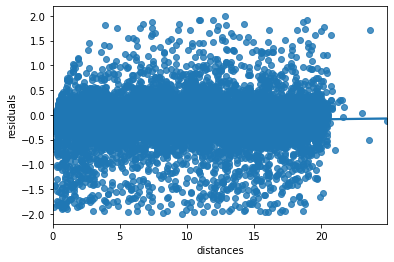

In [258]:
import seaborn as sns
sns.regplot(df.distances, df.residuals)

<ErrorbarContainer object of 3 artists>

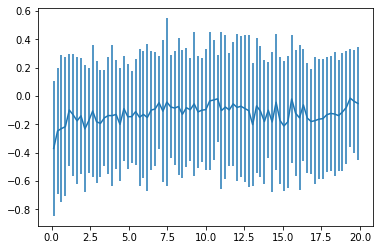

In [227]:
n_bins=80
x=np.linspace(0,20,n_bins)
s=x[1]/2
x+=s
x=x[:-1]

y=[]
err_y=[]
cont=0
for b in x:
    d=df[df.distances>b-s]
    d=d[d.distances<=b+s]
    y.append(np.mean(d.residuals))
    err_y.append(np.std(d.residuals))
    cont+=len(d)
y=np.array(y)   
err_y=np.array(err_y)

plt.errorbar(x,y,err_y)

Text(0, 0.5, 'Residuals means and errors')

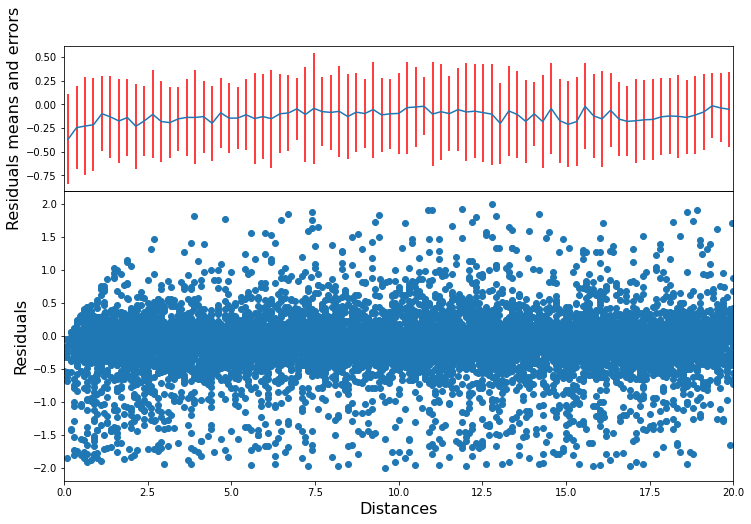

In [251]:
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))


ax2 = plt.subplot2grid(gridsize, (1, 0),colspan=2, rowspan=2)
ax2.scatter(df.distances.values, df.residuals.values)
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax1.errorbar(x,y,err_y,ecolor='red')
ax2.set_xlim([0, 20])
ax1.set_xlim([0, 20])


ax1.set_xticks([])
fig.subplots_adjust(hspace=0)

ax2.set_xlabel('Distances',fontsize=16)
ax2.set_ylabel('Residuals',fontsize=16)
ax1.set_ylabel('Residuals means and errors',fontsize=16)